In [214]:
!pip install gymnasium

In [215]:
import numpy as np
import torch
import torch.nn as nn
from collections import namedtuple, deque
from copy import deepcopy
import matplotlib.pyplot as plt

# Definition of a 3-layer neural net with tanh activation

In [216]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Net(nn.Module):
    def __init__(self, n_inputs, n_outputs, bias=True):
        super().__init__()
        self.activation_function= nn.Tanh()

        self.layer1 = nn.Linear( #<--- linear layer
            n_inputs, #<----------------#input features
            64,#<-----------------------#output features
            bias=bias)#<----------------bias

        self.layer2 = nn.Linear(
            64,
            32,
            bias=bias)

        self.layer3 = nn.Linear(
                    32,
                    n_outputs,
                    bias=bias)


    def forward(self, x):
        x = self.activation_function( self.layer1(x) )
        x = self.activation_function( self.layer2(x) )
        y = self.layer3(x)

        return y


# Q network definition

In [217]:
class Q_network(nn.Module):

    def __init__(self, env,  learning_rate=1e-4):
        super(Q_network, self).__init__()

        n_outputs = env.action_space.n

        #self.network = Net( ?? , ??)
        print( env.observation_space._shape[0], env.action_space.n)
        self.network = Net( env.observation_space._shape[0], env.action_space.n)
        print("Q network:")
        print(self.network)

        self.optimizer = torch.optim.Adam(self.network.parameters(),
                                          lr=learning_rate)

    def greedy_action(self, state):
        # greedy action = ??
        # greedy_a = 0
        qvals = self.get_qvals(state)
        greedy_a = torch.max(qvals, dim=-1)[1].item()
        return greedy_a

    def get_qvals(self, state):
        #out = ???
        out = self.network(state)
        return out

## Experience replay buffer

In [ ]:
class Experience_replay_buffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        

    def sample_batch(self, batch_size=32):
       

    def append(self, s_0, a, r, d, s_1):
       
       
    def burn_in_capacity(self):
        

    def capacity(self):
      

# DQN agent implementation

![alt text](DQN.png "Title")

In [ ]:
def from_tuple_to_tensor(tuple_of_np):
    tensor = torch.zeros((len(tuple_of_np), tuple_of_np[0].shape[0]))
    for i, x in enumerate(tuple_of_np):
        tensor[i] = torch.FloatTensor(x)
    return tensor


class DQN_agent:

    def __init__(self, env, rew_thre, buffer, learning_rate=0.001, initial_epsilon=0.6, batch_size= 64, seed=1):


    def take_step(self, mode='exploit'):
        

    # Implement DQN training algorithm
    def train(self, gamma=0.99, max_episodes=10000,
              network_update_frequency=10,
              network_sync_frequency=200):
        

    def save_models(self):
        torch.save(self.network, "Q_net")

    def load_models(self):
        self.network = torch.load("Q_net")
        self.network.eval()

    def plot_training_rewards(self):
        plt.plot(self.mean_training_rewards)
        plt.title('Mean training rewards')
        plt.ylabel('Reward')
        plt.xlabel('Episods')
        plt.show()
        plt.savefig('mean_training_rewards.png')
        plt.clf()

    def calculate_loss(self, batch):
        

        return loss


    def update(self):
        

    def initialize(self):
        self.training_rewards = []
        self.training_loss = []
        self.update_loss = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.rewards = 0
        self.step_count = 0

    def evaluate(self, eval_env):
        done = False
        s, _ = eval_env.reset()
        rew = 0
        while not done:
            action = self.network.greedy_action(torch.FloatTensor(s).to(device))
            s, r, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            rew += r

        print("Evaluation cumulative reward: ", rew)


# DDQN agent implementation

![alt text](DDQN.png "Title")

In [ ]:
class DDQN_agent(DQN_agent):

    def __init__(self, env, rew_thre, buffer, learning_rate=0.001, initial_epsilon=0.6, batch_size= 64, seed=1):
        super(DDQN_agent, self).__init__(env, rew_thre, buffer, learning_rate, initial_epsilon, batch_size, seed)


    def save_models(self):
        torch.save(self.network, "DDQN")

    def load_models(self):
        self.network = torch.load("DDQN")
        self.network.eval()


    def calculate_loss(self, batch):
        
        return loss


# Train and evaluate on cartpole

In [237]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
SEED = 1


4 2
Q network:
Net(
  (activation_function): Tanh()
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=2, bias=True)
)
4 2
Q network:
Net(
  (activation_function): Tanh()
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=2, bias=True)
)
Episode 826 Mean Rewards 406.12  Episode reward = 500.00   mean loss = 3.93		
Environment solved in 826 episodes!


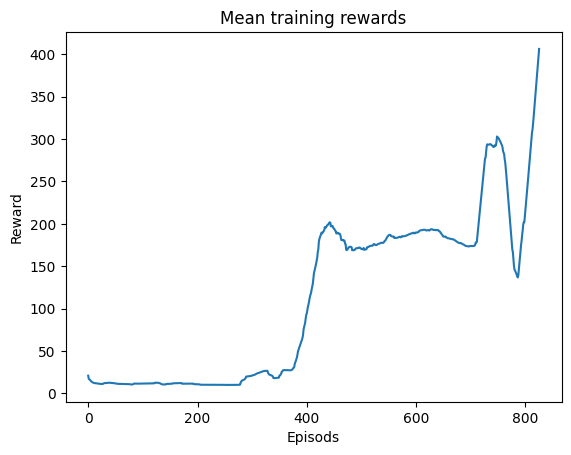

<Figure size 640x480 with 0 Axes>

In [239]:
import gymnasium as gym

set_seed(SEED)
env = gym.make("CartPole-v1", render_mode="rgb_array")
rew_threshold = 400
buffer = Experience_replay_buffer()
agent_ddqn = DDQN_agent(env, rew_threshold, buffer, initial_epsilon=0.7, seed=SEED)

state, _ = env.reset(seed=SEED)
agent_ddqn.train()

In [248]:
set_seed(seed=123)
eval_env = gym.make("CartPole-v1", render_mode="human")
agent_ddqn.seed = 123
agent_ddqn.evaluate(eval_env)

Evaluation cumulative reward:  500.0


4 2
Q network:
Net(
  (activation_function): Tanh()
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=2, bias=True)
)
4 2
Q network:
Net(
  (activation_function): Tanh()
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=2, bias=True)
)
Episode 1260 Mean Rewards 402.78  Episode reward = 500.00   mean loss = 11.28		
Environment solved in 1260 episodes!


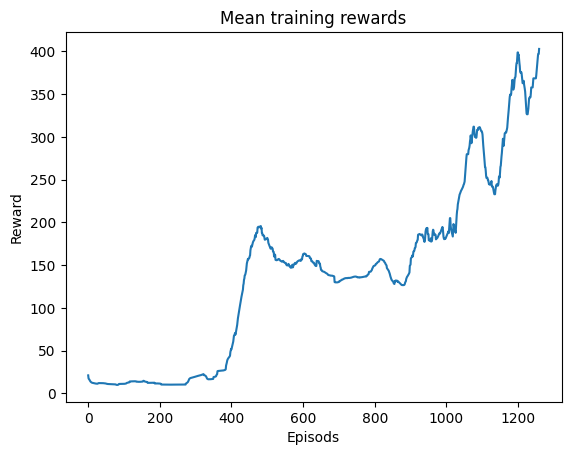

<Figure size 640x480 with 0 Axes>

In [241]:
import gymnasium as gym
set_seed(SEED)
env = gym.make("CartPole-v1", render_mode="rgb_array")
rew_threshold = 400
buffer = Experience_replay_buffer()
agent_dqn = DQN_agent(env, rew_threshold, buffer, initial_epsilon=0.7, seed=SEED)
agent_dqn.train()

In [247]:
set_seed(seed=123)
eval_env = gym.make("CartPole-v1", render_mode="human")
agent_dqn.seed = 123
agent_dqn.evaluate(eval_env)


Evaluation cumulative reward:  500.0
